# Import Libraries

In [297]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import sklearn
import random
import pickle
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.utils import shuffle
from tqdm import tqdm

# Import Dataset

In [3]:
path = 'Bone Break Classification'
class_list = os.listdir(path)
print(class_list)

['Fracture Dislocation', 'Comminuted fracture', 'Hairline Fracture', 'Greenstick fracture', 'Avulsion fracture']


In [4]:
X_train, y_train = [], []
X_test, y_test = [], []

for (index, _class) in enumerate(class_list):

    class_path = os.path.join(path, _class)

    train_path = os.path.join(class_path, 'Train')
    for img_path in os.listdir(train_path):
        full_path = os.path.join(train_path, img_path)
        image = cv2.imread(full_path, 0)
        image = cv2.resize(image, (256,256))
        X_train.append(image)
        y_train.append(index)

    test_path = os.path.join(class_path, 'Test')
    for img_path in os.listdir(test_path):
        full_path = os.path.join(test_path, img_path)
        image = cv2.imread(full_path, 0)
        image = cv2.resize(image, (256,256))
        X_test.append(image)
        y_test.append(index)

In [5]:
def preprocess(image_list, edge_detection_type='canny'):
    blurred_image = [cv2.medianBlur(img, 5) for img in image_list]

    if edge_detection_type == "sobel":
        sobel_edges = [
            cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3) + cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
            for img in blurred_image
        ]
        edge_detected_images = [cv2.convertScaleAbs(edge) for edge in sobel_edges]
    elif edge_detection_type == "canny":
        edge_detected_images = [
            cv2.Canny(img, 50, 100) for img in blurred_image
        ]
    else:
        raise ValueError("Invalid edge_detection_type. Choose 'sobel' or 'canny'.")

    return np.array(edge_detected_images)

In [183]:
X_train_preprocessed = preprocess(X_train, edge_detection_type='sobel')
X_test_preprocessed = preprocess(X_test, edge_detection_type='sobel')
X_train_preprocessed.shape

(587, 256, 256)

In [187]:
def extract_descriptors(image_list, descriptor_type="SIFT", max_descriptors=200):
    if descriptor_type == "SIFT":
        extractor = cv2.SIFT_create(nfeatures=max_descriptors)
        descriptor_dim = 128
    elif descriptor_type == "AKAZE":
        extractor = cv2.AKAZE_create()
        descriptor_dim = 64
    else:
        raise ValueError("Invalid descriptor_type")

    all_descriptors = []

    descriptor_counts = []

    for img in tqdm(image_list, desc=f"Extracting {descriptor_type} descriptors"):
        _, descriptors = extractor.detectAndCompute(img, None)

        if descriptors is None:
            descriptor_count = 0
            descriptors = np.zeros((0, descriptor_dim), dtype=np.float32)
        else:
            descriptor_count = descriptors.shape[0]
            if descriptor_count > max_descriptors:
                descriptors = descriptors[:max_descriptors]
            descriptors = normalize(descriptors, norm='l2')

        descriptor_counts.append(min(max_descriptors, descriptor_count))
        # descriptor_counts.append(descriptor_count)
        all_descriptors.append(descriptors)

    return all_descriptors, descriptor_counts

In [188]:
X_train_features_sift, X_train_sift_counts = extract_descriptors(X_train_preprocessed, "SIFT")
X_train_features_akaze, X_train_akaze_counts = extract_descriptors(X_train_preprocessed, "AKAZE")

X_test_features_sift, X_test_sift_counts = extract_descriptors(X_test_preprocessed, "SIFT")
X_test_features_akaze, X_test_akaze_counts = extract_descriptors(X_test_preprocessed, "AKAZE")

Extracting AKAZE descriptors: 100%|██████████| 73/73 [00:00<00:00, 99.54it/s]


Average Descriptors (SIFT): 198.73764906303236
Average Descriptors (AKAZE): 126.79045996592845


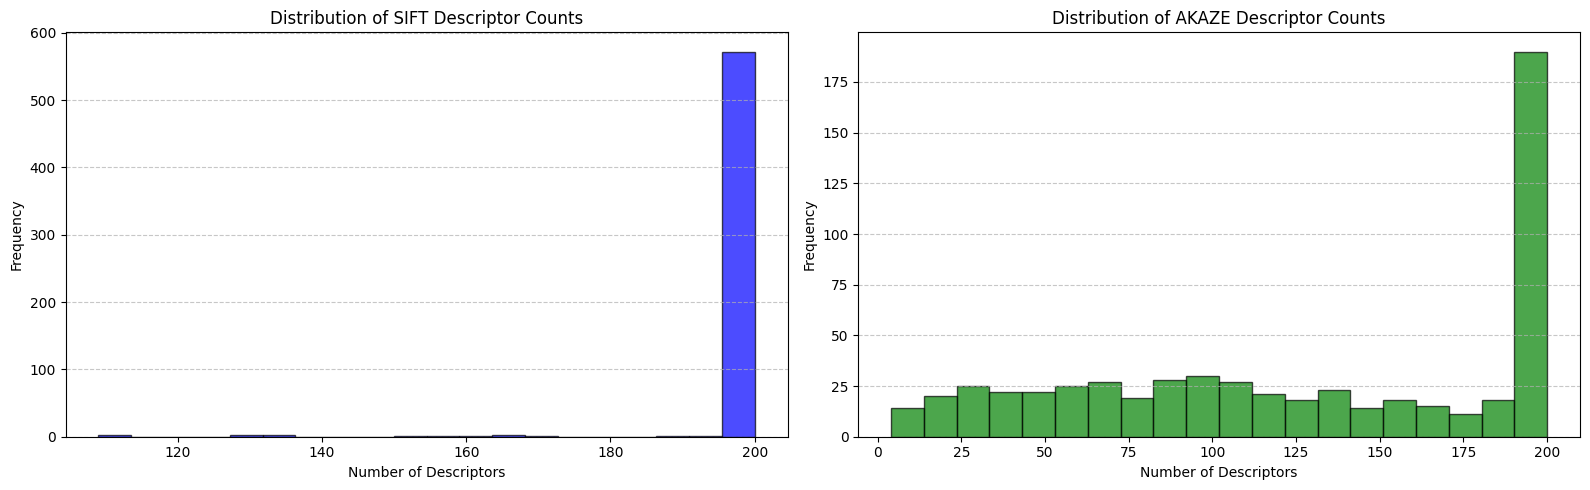

In [367]:
plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.hist(X_train_sift_counts, bins=20, color='blue', edgecolor='black', alpha=0.7)
plt.title("Distribution of SIFT Descriptor Counts")
plt.xlabel("Number of Descriptors")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2)
plt.hist(X_train_akaze_counts, bins=20, color='green', edgecolor='black', alpha=0.7)
plt.title("Distribution of AKAZE Descriptor Counts")
plt.xlabel("Number of Descriptors")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)

sift_descriptor_count = np.mean(X_train_sift_counts)
akaze_descriptor_count = np.mean(X_train_akaze_counts)

print(f'Average Descriptors (SIFT): {sift_descriptor_count}')
print(f'Average Descriptors (AKAZE): {akaze_descriptor_count}')

plt.tight_layout()
plt.show()

In [190]:
def create_bovw(descriptors_list, kmeans):
    bovw_features = []
    for descriptor in descriptors_list:
        histogram = np.zeros(kmeans.n_clusters)
        for desc in descriptor:
            if len(desc) == kmeans.n_features_in_:
                cluster_idx = kmeans.predict(desc.reshape(1, -1))[0]
                histogram[cluster_idx] += 1
        bovw_features.append(histogram)

    return np.array(bovw_features)

In [191]:
def get_n_clusters(num_descriptors=None, percentage=None):
  if num_descriptors is None or percentage is None:
    return 100
  else:
    return int(num_descriptors * (percentage / 100))

In [192]:
sift_descriptors = np.vstack([desc for desc in X_train_features_sift if desc.shape[0] > 0])
akaze_descriptors = np.vstack([desc for desc in X_train_features_akaze if desc.shape[0] > 0])

In [ ]:
kmeans_sift_20 = KMeans(n_clusters=get_n_clusters(sift_descriptor_count, 20), random_state=42).fit(sift_descriptors)
kmeans_akaze_20 = KMeans(n_clusters=get_n_clusters(akaze_descriptor_count, 20), random_state=42).fit(akaze_descriptors)

kmeans_sift_40 = KMeans(n_clusters=get_n_clusters(sift_descriptor_count, 40), random_state=42).fit(sift_descriptors)
kmeans_akaze_40 = KMeans(n_clusters=get_n_clusters(akaze_descriptor_count, 40), random_state=42).fit(akaze_descriptors)

kmeans_sift_80 = KMeans(n_clusters=get_n_clusters(sift_descriptor_count, 80), random_state=42).fit(sift_descriptors)
kmeans_akaze_80 = KMeans(n_clusters=get_n_clusters(akaze_descriptor_count, 80), random_state=42).fit(akaze_descriptors)

In [267]:
X_train_bovw_sift = create_bovw(X_train_features_sift, kmeans_sift_20)
X_train_bovw_akaze = create_bovw(X_train_features_akaze, kmeans_akaze_20)

X_test_bovw_sift = create_bovw(X_test_features_sift, kmeans_sift_20)
X_test_bovw_akaze = create_bovw(X_test_features_akaze, kmeans_akaze_20)

In [268]:
X_train_bovw = np.hstack([X_train_bovw_sift, X_train_bovw_akaze])
X_test_bovw = np.hstack([X_test_bovw_sift, X_test_bovw_akaze])

In [357]:
rf_model = RandomForestClassifier(n_estimators=400, max_depth=7, random_state=42)
rf_model.fit(X_train_bovw, y_train)
rf_predictions = rf_model.predict(X_test_bovw)

print("Random Forest Accuracy:", accuracy_score(y_test, rf_predictions))
print(classification_report(y_test, rf_predictions))

Random Forest Accuracy: 0.4520547945205479
              precision    recall  f1-score   support

           0       0.35      0.37      0.36        19
           1       0.40      0.71      0.51        14
           2       1.00      0.30      0.46        10
           3       0.54      0.44      0.48        16
           4       0.50      0.43      0.46        14

    accuracy                           0.45        73
   macro avg       0.56      0.45      0.46        73
weighted avg       0.52      0.45      0.45        73



In [332]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(n_estimators=500, max_depth=7, learning_rate=0.05)
xgb_model.fit(X_train_bovw, y_train)
xgb_predictions = xgb_model.predict(X_test_bovw)

print(f"Accuracy: {accuracy_score(y_test, xgb_predictions)}")
print(classification_report(y_test, xgb_predictions))

Accuracy: 0.4246575342465753
              precision    recall  f1-score   support

           0       0.38      0.26      0.31        19
           1       0.38      0.71      0.50        14
           2       0.38      0.30      0.33        10
           3       0.42      0.31      0.36        16
           4       0.57      0.57      0.57        14

    accuracy                           0.42        73
   macro avg       0.43      0.43      0.41        73
weighted avg       0.43      0.42      0.41        73



In [345]:
svc_model = SVC(kernel='rbf', C=1, random_state=42)
svc_model.fit(X_train_bovw, y_train)
svc_predictions = svc_model.predict(X_test_bovw)

print("SVC Accuracy:", accuracy_score(y_test, svc_predictions))
print(classification_report(y_test, svc_predictions))

SVC Accuracy: 0.3835616438356164
              precision    recall  f1-score   support

           0       0.40      0.32      0.35        19
           1       0.39      0.64      0.49        14
           2       0.33      0.20      0.25        10
           3       0.44      0.50      0.47        16
           4       0.27      0.21      0.24        14

    accuracy                           0.38        73
   macro avg       0.37      0.37      0.36        73
weighted avg       0.37      0.38      0.37        73



### Kalo performancenya naik, boleh dump pickle, kalau engga, jangan di dump

In [ ]:
# import pickle

# with open('/content/kmeans_sift.pkl', 'wb') as f:
#     pickle.dump(kmeans_sift_20, f)

# with open('/content/kmeans_akaze.pkl', 'wb') as f:
#     pickle.dump(kmeans_akaze_20, f)

# with open('/content/xgbboost.pkl', 'wb') as f:
#     pickle.dump(xgb_model, f)

# with open('/content/rf_model.pkl', 'wb') as f:
#     pickle.dump(rf_model, f)

# with open('/content/svc.pkl', 'wb') as f:
#     pickle.dump(svc_model, f)

In [369]:
with open("/content/kmeans_sift.pkl", 'rb') as f:
    kmeans_sift_tester = pickle.load(f)

with open("/content/kmeans_akaze.pkl", 'rb') as f:
    kmeans_akaze_tester = pickle.load(f)

with open("/content/rf_model.pkl", 'rb') as f:
    rf_tester = pickle.load(f)

random_image = [X_test[42]]

random_image = preprocess(random_image)

random_image_sift, _ = extract_descriptors(random_image, descriptor_type='SIFT')
random_image_akaze, _ = extract_descriptors(random_image, descriptor_type="AKAZE")

random_image_bovw_sift = create_bovw(random_image_sift, kmeans_sift_tester)
random_image_bovw_akaze = create_bovw(random_image_akaze, kmeans_akaze_tester)

random_image_bovw = np.hstack([random_image_bovw_sift, random_image_bovw_akaze])
rf_tester.predict(random_image_bovw)

Extracting AKAZE descriptors: 100%|██████████| 1/1 [00:00<00:00, 87.59it/s]


array([1])